# 모듈 import

In [1]:
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from glob import glob
from scipy import interpolate
import warnings
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn.metrics import mean_squared_error 
from math import sqrt
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
warnings.filterwarnings("ignore")
sys.path.append(str(Path(os.getcwd())))

# Path 설정

In [2]:
base_path = Path(os.getcwd()).parent.parent
sys.path.append(base_path)

In [3]:
water_lst = glob(f'{base_path}/datasource/competition_data/water_data/*.csv')
rain_lst = glob(f'{base_path}/datasource/competition_data/rf_data/*.csv')

water_df = pd.DataFrame()
rain_df = pd.DataFrame()
for w in water_lst:
    water_df = water_df.append(pd.read_csv(w))
for r in rain_lst:
    rain_df = rain_df.append(pd.read_csv(r))

# 폰트설정

In [4]:
plt.rc('font', family = 'Malgun Gothic')

# 타입 수정 및 데이터 추가 병합(water+rain)

In [5]:
# datetime
water_df['ymdhm'] = pd.to_datetime(water_df['ymdhm'], format = '%Y-%m-%d %H:%M:%S' )
rain_df['ymdhm'] = pd.to_datetime(rain_df['ymdhm'], format = '%Y-%m-%d %H:%M:%S' )

# merge to dataframe
merge_df = pd.merge(water_df, rain_df, how = 'left', on = 'ymdhm')

# 컬럼 수정

In [6]:
new_cols ={'ymdhm':"date",
           'swl':'팔당댐 현재수위',
           'inf':'팔당댐 유입량',
           'sfw':'팔당댐 저수량',
           'ecpc':'팔당댐 공용량',
           'tototf':'총 방류량',
           'tide_level':"강화대교 조위",
           'fw_1018662':'청담대교 유량',
           'fw_1018680':'잠수교 유량',
           'fw_1018683':'한강대교 유량',
           'fw_1019630':'행주대교 유량',
           'wl_1018662':'청담대교 수위',    
           'wl_1018680':'잠수교 수위',
           'wl_1018683':"한강대교 수위",
           'wl_1019630':"행주대교 수위",
           'rf_10184100':'대곡교 강수량',
           'rf_10184110':'진관교 강수량',
           'rf_10184140':'송정동 강수량'}
merge_df =merge_df.rename(columns = new_cols)

# 데이터 분리

In [7]:
# test set: 2022 06 01 ~
train = merge_df[-((merge_df['date'].dt.year==2022) & (merge_df['date'].dt.month>=6))].reset_index(drop =True)
test = merge_df[((merge_df['date'].dt.year==2022) & (merge_df['date'].dt.month>=6))].reset_index(drop =True)

# 기본 전처리

In [8]:
# 0이하의 값 일괄 nan값으로 변경

# 학습 및 검증셋
for i in list(train.columns[1:6]):
    error_lst = list(train[train[i]<=0][i].index)
    train.loc[error_lst, i] = np.nan
    
# 최종 예측을 위한 테스트셋    
for i in list(test.columns[1:6]):
    error_lst2 = list(test[test[i]<=0][i].index)
    test.loc[error_lst2, i] = np.nan

# Moving Average + Regression

In [9]:
# 2013년 데이터만 사용 
df_2013 = train[(train['date'].dt.year==2013)].reset_index(drop = True)
df_2013 = df_2013.fillna(df_2013.rolling(3, min_periods = 1, axis = 0,center = True).mean())
# df_2013 = df_2013.fillna(df_2013.rolling(6, min_periods = 1, axis = 0,center = True).mean())


#train
# 잠수교 유량데이터는 측정 센서가 없기때문에 전체 Null & 강화대교 조위 역시 필요없다고 판단
train_df =df_2013.drop(columns = ['잠수교 유량','강화대교 조위'])
train_df.isna().sum()

#test
test =test.drop(columns =['잠수교 유량','강화대교 조위'])

## Time Lag확인

<AxesSubplot:xlabel='date', ylabel='청담대교 수위'>

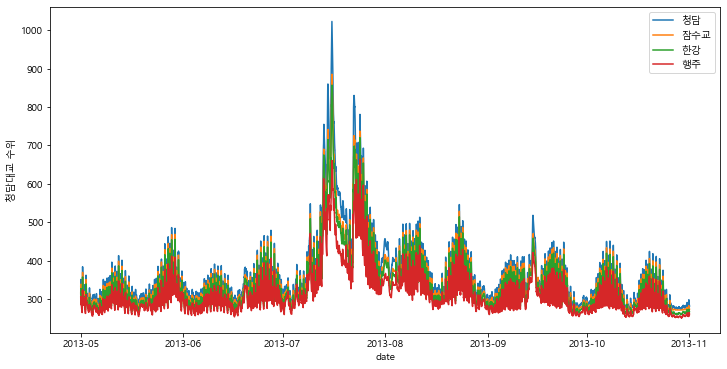

In [38]:
plt.figure(figsize = (12,6))
# sns.lineplot(train_df['date'],train_df['총 방류량'])
sns.lineplot(train_df['date'], train_df['청담대교 수위'],label = '청담')
sns.lineplot(train_df['date'], train_df['잠수교 수위'],label = '잠수교')
sns.lineplot(train_df['date'], train_df['한강대교 수위'],label = '한강')
sns.lineplot(train_df['date'], train_df['행주대교 수위'],label = '행주')

<AxesSubplot:xlabel='date', ylabel='팔당댐 유입량'>

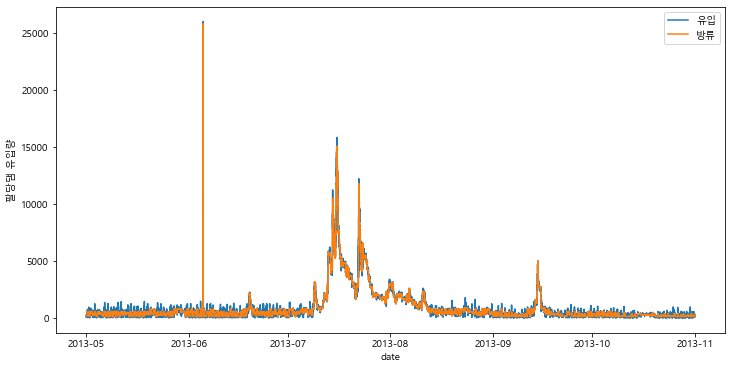

In [41]:
plt.figure(figsize = (12,6))
sns.lineplot(train_df['date'], train_df['팔당댐 유입량'],label = '유입')
sns.lineplot(train_df['date'], train_df['총 방류량'],label = '방류')

## 스케일링

In [10]:
# scaler = StandardScaler()
# concat_df = train_df['팔당댐 유입량']
# train_df = pd.DataFrame(scaler.fit_transform(train_df[['팔당댐 현재수위','팔당댐 저수량','총 방류량']]),columns = ['팔당댐 현재수위','팔당댐 저수량','총 방류량'])
# train_df = pd.concat([train_df,concat_df],axis = 1)
# train_df

In [11]:
scaler = StandardScaler()
train_df = pd.DataFrame(scaler.fit_transform(train_df[['팔당댐 현재수위','팔당댐 유입량','팔당댐 저수량','팔당댐 공용량','총 방류량']]),columns = ['팔당댐 현재수위','팔당댐 유입량','팔당댐 저수량','팔당댐 공용량','총 방류량'])

In [12]:

reg_df = train_df
# train
reg_x_data = reg_df[-reg_df['팔당댐 유입량'].isna()][['팔당댐 현재수위','팔당댐 저수량','팔당댐 공용량', '총 방류량']].reset_index(drop=True)
reg_y_data = reg_df[-reg_df['팔당댐 유입량'].isna()]['팔당댐 유입량'].reset_index(drop=True)
# train 데이터를 train/val분리
reg_x_train = reg_x_data.iloc[:-5000]
reg_y_train = reg_y_data.iloc[:-5000]
reg_x_val = reg_x_data.iloc[-5000:]
reg_y_val = reg_y_data.iloc[-5000:]
# test
test_index =list(reg_df[reg_df['팔당댐 유입량'].isna()].index)
reg_x_test = reg_df[reg_df['팔당댐 유입량'].isna()][['팔당댐 현재수위','팔당댐 저수량','팔당댐 공용량',  '총 방류량']].reset_index(drop=True)
reg_y_test = reg_df[reg_df['팔당댐 유입량'].isna()]['팔당댐 유입량'].reset_index(drop=True)

In [13]:
reg_df.shape, reg_x_train.shape,reg_x_val.shape,reg_x_test.shape, reg_y_train.shape, reg_y_val.shape, reg_y_test.shape

((26496, 5), (21282, 4), (5000, 4), (214, 4), (21282,), (5000,), (214,))

# 모델 테스트

## 랜덤포레스트

In [14]:
# RandongForest
kfold = KFold(n_splits=2, shuffle=True)

rf = RandomForestRegressor(n_jobs=-1)

params = {
    "n_estimators" : (100, 150, 200)
}

grid_cv = GridSearchCV(rf,
                       param_grid=params,
                       cv = kfold,
                       n_jobs=-1)
grid_cv.fit(reg_x_train, reg_y_train)

# rmse 
model = grid_cv.best_estimator_
reg_y_val_pred = model.predict(reg_x_val)
rmse = np.sqrt(mean_squared_error(reg_y_val, reg_y_val_pred))
print(f'RMSE : {rmse}')

RMSE : 0.1012929550947836


## 릿지

In [15]:
# Ridge
ridge = Ridge(alpha = 0.05, max_iter = 10000)
model2 = ridge.fit(reg_x_train, reg_y_train)
reg_y_val_pred = model2.predict(reg_x_val)
rmse = np.sqrt(mean_squared_error(reg_y_val, reg_y_val_pred))
print(f'RMSE : {rmse}')

RMSE : 0.0803884092612606


# 팔당댐 유입량 예측 및 보간

In [16]:
label =model2.predict(reg_x_test)
reg_y_test[:] = list(label)

In [17]:
reg_y_test

0     -0.369625
1     -0.369029
2     -0.434801
3     -0.236491
4     -0.234156
         ...   
209   -0.500327
210   -0.498702
211   -0.496028
212   -0.526868
213   -0.522805
Name: 팔당댐 유입량, Length: 214, dtype: float64

In [18]:
new_train_df = pd.concat([reg_x_train,reg_y_train],axis =1)
new_val_df = pd.concat([reg_x_val,reg_y_val],axis = 1)
new_test_df = pd.concat([reg_x_test,reg_y_test],axis = 1)

In [19]:
new_train_df.shape, new_val_df.shape, new_test_df.shape

((21282, 5), (5000, 5), (214, 5))

In [20]:
new_data = pd.concat([new_train_df, new_val_df])
new = pd.concat([new_data,new_test_df])

In [21]:
# 역스케일링
new_df = pd.DataFrame(scaler.inverse_transform(new),columns =new.columns )
new_df

,팔당댐 현재수위,팔당댐 저수량,팔당댐 공용량,총 방류량,팔당댐 유입량
0,25.290,2772.396441,227.165547,9.713186,140.692910
1,25.289,2762.495074,227.184829,9.820704,163.485642
2,25.289,2762.495074,227.184829,9.820704,163.485642
3,25.288,2749.293252,227.204110,9.820704,163.485642
4,25.278,2627.176397,227.441914,9.821175,63.617487
...,...,...,...,...,...
26491,25.144,1029.755916,230.552647,9.796182,170.416161
26492,25.140,976.948627,230.655481,9.797125,172.801503
26493,25.145,1042.957738,230.526939,9.828720,176.729198
26494,25.140,976.948627,230.655481,9.600952,131.444683


이렇게되면 데이터가 다섞인다...test데이터를 마지막에CONCAT했으니 뒤에서 N번째 것으로 자른다??

In [22]:
fill_data =pd.DataFrame(new_df.iloc[-214:,-1]).set_index(df_2013[df_2013['팔당댐 유입량'].isna()].index)
fill_data

,팔당댐 유입량
105,362.334806
106,363.209680
292,266.632295
369,557.824448
370,561.253809
...,...
26289,170.416161
26290,172.801503
26416,176.729198
26433,131.444683


In [23]:
# 2013년 팔당댐 유입량 보간
df_2013.loc[df_2013['팔당댐 유입량'].isna(),'팔당댐 유입량']= pd.Series(fill_data['팔당댐 유입량'])

In [24]:
df_2013.isna().sum()

date        0
팔당댐 현재수위    0
팔당댐 유입량     0
팔당댐 저수량     0
팔당댐 공용량     0
총 방류량       0
강화대교 조위     0
청담대교 수위     0
청담대교 유량     0
잠수교 수위      0
잠수교 유량      0
한강대교 수위     0
한강대교 유량     0
행주대교 수위     0
행주대교 유량     0
대곡교 강수량     0
진관교 강수량     0
송정동 강수량     0
dtype: int64

위에것이 해결되면 test데이터가 중요해진다...어떻게 할것인가...

# test데이터 결측값처리

In [37]:
copy_test = test.fillna(test.rolling(9, min_periods = 1, axis = 0,center = True).mean())

<AxesSubplot:xlabel='팔당댐 유입량', ylabel='팔당댐 유입량'>

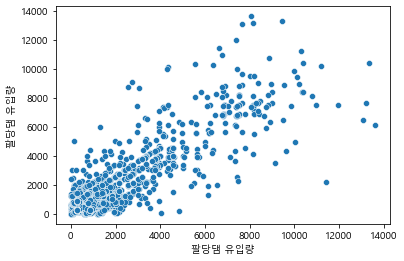

In [41]:
sns.scatterplot(copy_test['팔당댐 유입량'],copy_test['팔당댐 유입량'].shift(2))

In [38]:
copy_test[copy_test['팔당댐 유입량'].isna()]

,date,팔당댐 현재수위,팔당댐 유입량,팔당댐 저수량,팔당댐 공용량,총 방류량,청담대교 수위,청담대교 유량,잠수교 수위,한강대교 수위,한강대교 유량,행주대교 수위,행주대교 유량,대곡교 강수량,진관교 강수량,송정동 강수량
1087,2022-06-08 13:10:00,NaN,NaN,NaN,NaN,NaN,0.0,243.290000,0.0,0.0,270.72,0.0,292.61,0.0,0.0,0.0
1088,2022-06-08 13:20:00,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,141.42,0.0,301.39,0.0,0.0,0.0
1089,2022-06-08 13:30:00,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,84.85,0.0,337.86,0.0,0.0,0.0
1090,2022-06-08 13:40:00,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,137.38,0.0,347.31,0.0,0.0,0.0
1091,2022-06-08 13:50:00,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,149.29,0.0,366.60,0.0,0.0,0.0
1092,2022-06-08 14:00:00,NaN,NaN,NaN,NaN,NaN,0.0,243.290000,0.0,0.0,125.26,0.0,366.60,0.0,0.0,0.0
1093,2022-06-08 14:10:00,NaN,NaN,NaN,NaN,NaN,0.0,259.035000,0.0,0.0,68.99,0.0,347.31,0.0,0.0,0.0
1094,2022-06-08 14:20:00,NaN,NaN,NaN,NaN,NaN,0.0,271.646667,0.0,0.0,-36.68,0.0,337.86,0.0,0.0,0.0
1095,2022-06-08 14:30:00,NaN,NaN,NaN,NaN,NaN,0.0,286.647500,0.0,0.0,-40.88,0.0,319.36,0.0,0.0,0.0
1096,2022-06-08 14:40:00,NaN,NaN,NaN,NaN,NaN,0.0,243.290000,0.0,0.0,-20.47,0.0,310.31,0.0,0.0,0.0


In [26]:
df_2013 = df_2013.drop(columns = ['잠수교 유량', '강화대교 조위'])
df_2013

,date,팔당댐 현재수위,팔당댐 유입량,팔당댐 저수량,팔당댐 공용량,총 방류량,청담대교 수위,청담대교 유량,잠수교 수위,한강대교 수위,한강대교 유량,행주대교 수위,행주대교 유량,대곡교 강수량,진관교 강수량,송정동 강수량
0,2013-05-01 00:00:00,25.290,151.0,236.48,7.53,151.0,332.7,639.32,317.2,314.0,-993.41,305.3,958.36,0.0,0.0,0.0
1,2013-05-01 00:10:00,25.289,173.8,236.45,7.56,173.8,338.7,690.47,327.2,316.0,-775.22,302.3,911.07,0.0,0.0,0.0
2,2013-05-01 00:20:00,25.289,173.8,236.45,7.56,173.8,343.7,734.64,334.2,324.0,-380.85,297.3,834.96,0.0,0.0,0.0
3,2013-05-01 00:30:00,25.288,173.8,236.41,7.59,173.8,347.7,770.98,337.2,326.0,-52.67,292.3,762.23,0.0,0.0,0.0
4,2013-05-01 00:40:00,25.278,73.9,236.04,7.96,173.9,349.7,789.50,338.2,327.0,237.34,288.3,706.48,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26491,2013-10-31 23:10:00,25.231,171.9,234.40,9.60,171.9,280.7,280.22,274.2,268.0,372.96,259.3,366.60,0.0,0.0,0.0
26492,2013-10-31 23:20:00,25.224,71.0,234.10,9.90,171.0,280.7,280.22,274.2,268.0,348.63,259.3,366.60,0.0,0.0,0.0
26493,2013-10-31 23:30:00,25.219,70.6,233.91,10.09,170.6,280.7,280.22,273.2,267.0,315.76,260.3,376.45,0.0,0.0,0.0
26494,2013-10-31 23:40:00,25.219,70.2,233.91,10.09,170.2,280.7,280.22,273.2,267.0,263.13,260.3,376.45,0.0,0.0,0.0


In [27]:
df_2013.isna().sum()

date        0
팔당댐 현재수위    0
팔당댐 유입량     0
팔당댐 저수량     0
팔당댐 공용량     0
총 방류량       0
청담대교 수위     0
청담대교 유량     0
잠수교 수위      0
한강대교 수위     0
한강대교 유량     0
행주대교 수위     0
행주대교 유량     0
대곡교 강수량     0
진관교 강수량     0
송정동 강수량     0
dtype: int64

In [30]:
test['팔당댐 유입량'].corr(test['총 방류량'])

0.926788485013277

- 방류량을 다른데이터로 추론
- 방류량 포함 다른데이터로 유입량 추론
- 방류량, 유입량 포함 다른 데이터로 현재수위 or저수량 추론 후 나머지 한개 추론

In [31]:
# train/ test분리
columns = list(df_2013.columns[6:])
train = df_2013.iloc[:-5000]
test = df_2013.iloc[-5000:]

# 스케일링
scaler = StandardScaler()
train = pd.DataFrame(scaler.fit_transform(train),columns = list(train.columns))
test = pd.DataFrame(scaler.transform(test),columns = list(test.columns))
# x, y분리
x_train =  train[columns]
y_train = train['총 방류량']
x_test = test[columns]
y_test = test['총 방류량']

TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>, <class 'numpy.dtype[float64]'>)

In [ ]:
train_df = pd.DataFrame(scaler.fit_transform(train_df[['팔당댐 현재수위','팔당댐 유입량','팔당댐 저수량','팔당댐 공용량','총 방류량']]),columns = ['팔당댐 현재수위','팔당댐 유입량','팔당댐 저수량','팔당댐 공용량','총 방류량'])
train_df

In [28]:
x_train

,청담대교 수위,청담대교 유량,잠수교 수위,한강대교 수위,한강대교 유량,행주대교 수위,행주대교 유량,대곡교 강수량,진관교 강수량,송정동 강수량
0,332.7,639.32,317.2,314.0,-993.41,305.3,958.36,0.0,0.0,0.0
1,338.7,690.47,327.2,316.0,-775.22,302.3,911.07,0.0,0.0,0.0
2,343.7,734.64,334.2,324.0,-380.85,297.3,834.96,0.0,0.0,0.0
3,347.7,770.98,337.2,326.0,-52.67,292.3,762.23,0.0,0.0,0.0
4,349.7,789.50,338.2,327.0,237.34,288.3,706.48,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
21491,288.7,325.72,284.2,278.0,254.89,271.3,493.58,0.0,0.0,0.0
21492,288.7,325.72,284.2,278.0,242.55,270.3,482.26,0.0,0.0,0.0
21493,287.7,319.84,284.2,278.0,222.00,269.3,471.08,0.0,0.0,0.0
21494,287.7,319.84,284.2,277.0,234.00,268.3,460.03,0.0,0.0,0.0
